# Working with the IAM_Handwriting Dataset
I am working on a Neural Network (nn) that will recognize word that are hand written

Install required libraries and load them into script

In [1]:
%pip install torch torchvision Pillow matplotlib numpy pandas tqdm requests --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tarfile
import requests
from tqdm import tqdm
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

Note: you may need to restart the kernel to use updated packages.


Download and save the dataset

In [2]:
# Function to download and unzip dataset from URL
def download_and_unzip(url, extract_to="Datasets", chunk_size=1024*1024):
    http_response = urlopen(url)

    data = b""
    iterations = http_response.length // chunk_size + 1
    for _ in tqdm(range(iterations)):
        data += http_response.read(chunk_size)

    zipfile = ZipFile(BytesIO(data))
    zipfile.extractall(path=extract_to)

In [3]:
# Define dataset path
dataset_path = os.path.join("Datasets", "IAM_Words")

# If not already built, will download and store dataset into folder this script is in
#
# If already downloaded, the script will pass without doing anything more
if not os.path.exists(dataset_path):
    # Download and extract dataset
    download_and_unzip("https://git.io/J0fjL", extract_to="Datasets")

    # Extract words.tgz file inside the dataset
    file = tarfile.open(os.path.join(dataset_path, "words.tgz"))
    file.extractall(os.path.join(dataset_path, "words"))

Define directories and parse the word.txt file to record image information

In [4]:
# Once downloaded, process dataset
# Load images and labels from the extracted dataset
image_dir = os.path.join(dataset_path, "words")
labels_file = os.path.join(dataset_path, "words.txt")

In [5]:
def parse_words_file(words_file, image_root_dir):
    data = []
    count = 0  # Initialize count here
    with open(words_file, 'r') as file:
        for line in file:
            count += 1  # Correctly increment count
            if line.startswith("#"):
                continue
            
            parts = line.split()
            word_id = parts[0]  # e.g., a01-000u-05-02
            
            # Split word_id into parts
            word_id_parts = word_id.split('-')
            first_part = word_id_parts[0]  # e.g., a01
            second_part = '-'.join(word_id_parts[:2])  # e.g., a01-000u
            
            usability = parts[1]
            gray_level = parts[2]
            bounding_box = ' '.join(parts[3:7])
            grammatical_tag = parts[7]
            transcription = ' '.join(parts[8:])

            # Construct the correct image path
            img_folder = os.path.join(image_root_dir, first_part, second_part)  # e.g., "Datasets/IAM_Words/words/a01/a01-000u"
            img_name = f"{word_id}.png"  # e.g., "a01-000u-05-02.png"
            img_path = os.path.join(img_folder, img_name)

            # # Print the constructed path for debugging
            # if count % 1000 == 0:
            #     print(f"Constructed image path: {img_path}")

            data.append([img_path, usability, gray_level, bounding_box, grammatical_tag, transcription])
    
    df = pd.DataFrame(data, columns=['image_path', 'usability', 'gray_level', 'bounding_box', 'grammatical_tag', 'transcription'])
    return df

# Assuming you have the correct directories
image_root_dir = 'Datasets/IAM_Words/words'
words_file = 'Datasets/IAM_Words/words.txt'

# Parse the words.txt file
df = []
df = parse_words_file(words_file, image_root_dir)

# Preview the DataFrame
print(df.head())

                                          image_path usability gray_level  \
0  Datasets/IAM_Words/words\a01\a01-000u\a01-000u...        ok        154   
1  Datasets/IAM_Words/words\a01\a01-000u\a01-000u...        ok        154   
2  Datasets/IAM_Words/words\a01\a01-000u\a01-000u...        ok        154   
3  Datasets/IAM_Words/words\a01\a01-000u\a01-000u...        ok        154   
4  Datasets/IAM_Words/words\a01\a01-000u\a01-000u...        ok        154   

      bounding_box grammatical_tag transcription  
0    408 768 27 51              AT             A  
1   507 766 213 48              NN          MOVE  
2    796 764 70 50              TO            to  
3   919 757 166 78              VB          stop  
4  1185 754 126 61             NPT           Mr.  


Create a handwriting dataset class, include padding for various image sizes

In [6]:
class HandwritingDataset(Dataset):
    def __init__(self, df, image_root_dir, transform=None):
        self.df = df
        self.image_root_dir = image_root_dir
        self.transform = transform
        self.char_to_idx = self.build_vocab(df['transcription'])
        self.idx_to_char = {v: k for k, v in self.char_to_idx.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']  # Assuming 'image_path' is the correct column
        label = self.df.iloc[idx]['transcription']

        try:
            image = Image.open(img_path).convert('L')
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            image = Image.new('L', (100, 32), 255)
            label = "" 

        if self.transform:
            image = self.transform(image)

        label_encoded = [self.char_to_idx[char] for char in label] if label else []

        return image, label_encoded  # Return labels as lists

    def build_vocab(self, labels):
        all_chars = set(''.join(labels))
        char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
        char_to_idx['<BLANK>'] = 0
        return char_to_idx

In [7]:
# Define the transformations, including normalization
transform = transforms.Compose([
    transforms.Resize((128, 32)),  # Resize images to 128x32
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize with mean and std
])

# Define the collate function
def collate_fn(batch):
    images, labels = zip(*batch)  # Unzip the batch

    # Pad the labels to the maximum length in the batch
    max_length = max(len(label) for label in labels)
    labels_padded = [label + [0] * (max_length - len(label)) for label in labels]  # Pad with 0 (for <BLANK>)
    
    # Convert images to a tensor
    images = torch.stack(images)

    return images, torch.tensor(labels_padded)

In [8]:
# Define the dataset and image directory
image_root_dir = r'Datasets\IAM_Words\words'
dataset = HandwritingDataset(df=df, image_root_dir=image_root_dir, transform=transform)

In [30]:
# Loop through the DataLoader and print the batch details
print("Loading batch...")
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx+1}")
    
    # Print the shape of the image batch
    print(f"Image batch shape: {images.size()}")  # e.g., torch.Size([batch_size, channels, height, width])
    
    # Print the labels
    print(f"Labels: {labels}")
    
    break  # Only preview the first batch for now


Loading batch...
Batch 1
Image batch shape: torch.Size([32, 1, 128, 32])
Labels: tensor([[33, 62, 71, 72, 73,  0,  0,  0,  0],
        [72, 61, 68, 76, 67,  0,  0,  0,  0],
        [56, 68, 67, 57, 74, 56, 73, 68, 71],
        [72, 68, 55, 58, 71,  0,  0,  0,  0],
        [69, 58, 68, 69, 65, 58,  0,  0,  0],
        [57, 54, 67, 56, 58,  0,  0,  0,  0],
        [55, 71, 58, 54, 64,  0,  0,  0,  0],
        [56, 68, 67, 73, 71, 68, 65,  0,  0],
        [54, 67, 57,  0,  0,  0,  0,  0,  0],
        [55, 58, 59, 68, 71, 58,  0,  0,  0],
        [54, 67, 57,  0,  0,  0,  0,  0,  0],
        [11,  0,  0,  0,  0,  0,  0,  0,  0],
        [62, 72,  0,  0,  0,  0,  0,  0,  0],
        [59, 71, 68, 66,  0,  0,  0,  0,  0],
        [54, 71, 58,  0,  0,  0,  0,  0,  0],
        [ 7,  0,  0,  0,  0,  0,  0,  0,  0],
        [60, 68, 62, 67, 60,  0,  0,  0,  0],
        [11,  0,  0,  0,  0,  0,  0,  0,  0],
        [54, 71, 58,  0,  0,  0,  0,  0,  0],
        [60, 74, 62, 72, 58,  0,  0,  0,  0],

Data Integrity

In [31]:
# Check the length of the dataset
print(f"Total samples in dataset: {len(dataset)}")

# Check for any missing image paths in the DataFrame
# Assuming 'image_path' is the correct name of the column that contains image paths
missing_images = df[~df['image_path'].apply(os.path.exists)]

# Print the missing images
if missing_images.empty:
    print("All images are present.")
else:
    print("Missing images:")
    print(missing_images)
    


Total samples in dataset: 115320
All images are present.


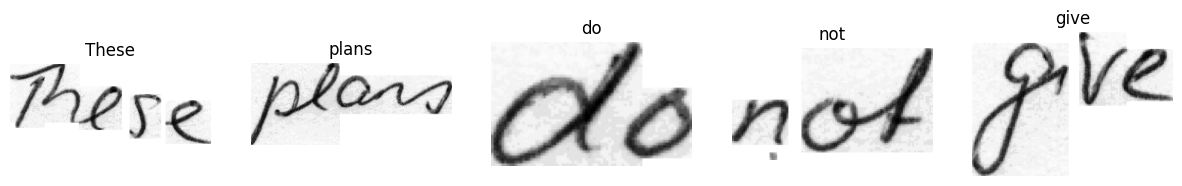

In [32]:
# Visualize a few samples
def visualize_samples(df, n_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(n_samples):
        j = i + 1000
        img_path = df.iloc[j]['image_path']
        label = df.iloc[j]['transcription']
        
        image = Image.open(img_path).convert('L')  # Load the image
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

visualize_samples(df)